# Final Project

In [53]:
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import pystan
import csv
from datetime import date
from datetime import timedelta

In [54]:
# import data from the csv file
raw_data = []
with open('weekly_in_situ_co2_mlo.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        raw_data.append(row)
just_values =raw_data[44::]

In [55]:
# convert dates to time since 
raw_dates = [point[0] for point in just_values]
datetime_dates = [date.fromisoformat(x) for x in raw_dates]
time = [(date.fromisoformat(x)-date.fromisoformat(just_values[0][0]))/timedelta(days = 1) for x in raw_dates]
# extract the co2 data set
co2_data = [float(point[1]) for point in just_values]

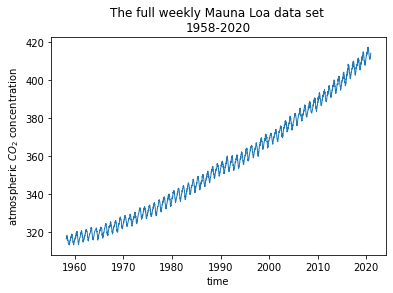

In [69]:
plt.plot_date(datetime_dates, co2_data,  linestyle = 'solid' , linewidth=1, markersize=0)
plt.title('The full weekly Mauna Loa data set \n1958-2020')
plt.ylabel('atmospheric $CO_2$ concentration')
plt.xlabel('time')
plt.show()

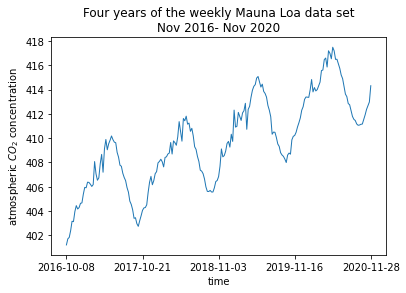

In [70]:
plt.plot_date(datetime_dates[-54*4::], co2_data[-54*4::], linestyle = 'solid' , linewidth=1, markersize=0)
plt.xticks(np.arange(min(datetime_dates[-54*4::]), max(datetime_dates[-54*4::])+timedelta(days = 1), timedelta(weeks = 54)))
plt.title('Four years of the weekly Mauna Loa data set\nNov 2016- Nov 2020')
plt.ylabel('atmospheric $CO_2$ concentration')
plt.xlabel('time')
plt.show()

In [41]:
data = {
    'length' : len(just_values),
    'time' : time,
    'co2' : co2_data
}

In [42]:
basic_model_stan_code = """

data {  
    int<lower=1> length;  // number of data points
    real<lower=0> time[length];  // time in days since start of data collection
    co2<lower=0> co2[length]; // the co2 concentration at a given date
}

parameters {
    real lambd;  // rate lambda for the exponential
}

model {
    lambd ~ gamma(alpha, beta);  // prior over lambda
    for(i in 1:num_calls) {
        waiting_times[i] ~ exponential(lambd);  // likelihood function
    }
}

"""

- fourier transform
- Asymmetrical waves (saw-tooth)
- band-pass filter
- 